# Example : complex conductivities
## Graph setup
First we setup the graph, boundary conditions and graph Laplacian

In [1]:
using Plots, LinearAlgebra, Test, DataFrames
x = [-1,1,-1,1,0,0]
y = [1,1,0,0,1,0]
∇ = [ 1 0 0 0 -1  0
      0 1 0 0 -1  0
      0 0 1 0  0 -1
      0 0 0 1  0 -1
      0 0 0 0  1 -1 ]
σr = [2,1,1,3,1]
σi = [2,1,1,2,3]
ω = 1
𝐁 = [1,2,3,4];
𝐈 = [5,6];
n𝐈 =length(𝐈); n𝐁 = length(𝐁);
n𝐄, n𝐕 = size(∇)

fs = I(n𝐁)
L(σ) = ∇'*diagm(σ)*∇;

## Graph plotting

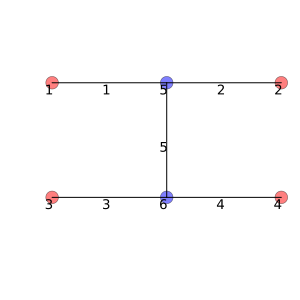

In [2]:
scatter(x[𝐈],y[𝐈], color="blue",markersize=7,markeralpha=0.5);
scatter!(x[𝐁],y[𝐁], color="red",markersize=7,markeralpha=0.5);
for i in eachindex(x)
  annotate!(x[i], y[i], text("$i",:black,:top,:right,9))
end
for (i, r) in enumerate(eachrow(∇))
  i1, i2 = findall(abs.(r) .> 0)
  plot!([x[i1], x[i2]], [y[i1], y[i2]], color="black", lw=1)
  annotate!((x[i1]+x[i2])/2, (y[i1]+y[i2])/2, text("$i", :black, :top,:right,9))
end
p=plot!(legend=:none, aspect_ratio=:equal, axis=false, grid=false,size=(300,300))

## Jacobian for one dirichlet boundary condition

In [3]:
R𝐈= I(n𝐕)[𝐈,:] # restriction to interior nodes
R𝐁= I(n𝐕)[𝐁,:] # restriction to boundary nodes

# Dirichlet problem solve
function dirsolve(σ,f)
  u = zeros(ComplexF64,n𝐕)
  u[𝐁] = f
  u[𝐈] = -L(σ)[𝐈,𝐈]\(L(σ)[𝐈,𝐁]*f)
  return u
end

# Forward problem and Jacobian
ℒ(σr,σi,u0,u1,u1b) = [
            (L(σr)*u0)[𝐈]
            (L(σr+im*ω*σi)*u1)[𝐈]
            (L(σr-im*ω*σi)*u1b)[𝐈]
            u0[𝐁]
            u1[𝐁]
            u1b[𝐁]
]
ℳ(σr,σi,u0,u1,u1b) =
[ σr .* abs2.(∇*u0)
  σr .* (∇*u1) .* (∇*u1b) ]

Dℒ(σr,σi,u0,u1,u1b) = [
    R𝐈*∇'*diagm(∇*u0)   zeros(n𝐈,n𝐄)            R𝐈*L(σr)      zeros(n𝐈,n𝐕)     zeros(n𝐈,n𝐕)
    R𝐈*∇'*diagm(∇*u1)   im*ω*R𝐈*∇'*diagm(∇*u1)  zeros(n𝐈,n𝐕)  R𝐈*L(σr+im*ω*σi) zeros(n𝐈,n𝐕)
    R𝐈*∇'*diagm(∇*u1b) -im*ω*R𝐈*∇'*diagm(∇*u1b) zeros(n𝐈,n𝐕)  zeros(n𝐈,n𝐕)     R𝐈*L(σr-im*ω*σi)
    zeros(n𝐁,n𝐄)        zeros(n𝐁,n𝐄)           R𝐁            zeros(n𝐁,n𝐕)    zeros(n𝐁,n𝐕)
    zeros(n𝐁,n𝐄)        zeros(n𝐁,n𝐄)           zeros(n𝐁,n𝐕)  R𝐁              zeros(n𝐁,n𝐕)
    zeros(n𝐁,n𝐄)        zeros(n𝐁,n𝐄)           zeros(n𝐁,n𝐕)  zeros(n𝐁,n𝐕)    R𝐁
]

Dℳ(σr,σi,u0,u1,u1b) = [
 diagm(abs2.(∇*u0))     zeros(n𝐄,n𝐄) 2diagm(σr .* (∇*u0))*∇ zeros(n𝐄,n𝐕)           zeros(n𝐄,n𝐕)
 diagm((∇*u1).*(∇*u1b)) zeros(n𝐄,n𝐄) zeros(n𝐄,n𝐕)           diagm(σr .* (∇*u1b))*∇ diagm(σr .* (∇*u1))*∇
];

## Assemble Jacobian and injectivity matrix for all boundary conditions

In [4]:
function jacobian(σr,σi,fs)
  N = size(fs,2) # number of Dirichlet boundary conditions
  # Solve Dirichlet problems and calculate Jacobians for each boundary condition
  u0s = zeros(ComplexF64,n𝐕,N)
  u1s = zeros(ComplexF64,n𝐕,N)
  Dℒs = Vector{Any}(undef,N)
  Dℳs = Vector{Any}(undef,N)
  for j=1:N
    u0s[:,j] = dirsolve(σr,fs[:,j])
    u1s[:,j] = dirsolve(σr+im*ω*σi,fs[:,j])
    Dℒs[j] = Dℒ(σr,σi,u0s[:,j],u1s[:,j],conj(u1s[:,j]))
    Dℳs[j] = Dℳ(σr,σi,u0s[:,j],u1s[:,j],conj(u1s[:,j]))
  end

  # Assemble full Jacobian
  𝒜 = zeros(ComplexF64,3N*n𝐕+2N*n𝐄,2n𝐄+3N*n𝐕)
  for j=1:N
    𝒜[ (j-1)*3n𝐕 .+ (1:3n𝐕)         , 1:2n𝐄 ] = Dℒs[j][:,1:2n𝐄]
    𝒜[ 3N*n𝐕 + (j-1)*2n𝐄 .+ (1:2n𝐄) , 1:2n𝐄 ] = Dℳs[j][:,1:2n𝐄]
    𝒜[ (j-1)*3n𝐕 .+ (1:3n𝐕)         , 2n𝐄 .+ (j-1)*3n𝐕 .+ (1:3n𝐕) ] = Dℒs[j][:,2n𝐄 .+ (1:3n𝐕)]
    𝒜[ 3N*n𝐕 .+ (j-1)*2n𝐄 .+ (1:2n𝐄), 2n𝐄 .+ (j-1)*3n𝐕 .+ (1:3n𝐕) ] = Dℳs[j][:,2n𝐄 .+ (1:3n𝐕)]
  end
  return 𝒜
end;

# Assemble matrix for injectivity condition
function injectivity_condition(σr,σi,fs)
  N = size(fs,2)
  A = zeros(ComplexF64,N*n𝐄,n𝐄)
  for j=1:N
    u1 = dirsolve(σr+im*ω*σi,fs[:,j])
    A[(j-1)*n𝐄 .+ (1:n𝐄),:] = -im*diagm(∇*conj(u1))*∇*R𝐈'*inv(L(σr+im*ω*σi)[𝐈,𝐈])*R𝐈*∇'*diagm(∇*u1)
  end
  return(A)
end;

## Some numerical tests for injectivity
Here should see that the linearized inverse problem is not injective for $N=1$
and $N=2$, but is for $N=3$ and $N=4$. In this example, the condition number
improves (is smaller) with larger $N$. We also include the rank of the complex
matrix $A = [A^{(1)};\ldots;A^{(N)}]$ and of its real part. We can see that as
a complex matrix $A$ has at least $\sigma' + \jmath\omega_1\sigma''$ in its
nullspace.

In [5]:
N = 4
rankJ = zeros(Int64,N)
rankA = zeros(Int64,N)
rankrealA = zeros(Int64,N)
condJ = zeros(N)
sizeJ = Vector{}(undef,N)
As = Vector{}(undef,N)
for j=1:4
    J = jacobian(σr,σi,fs[:,1:j])
    A = injectivity_condition(σr,σi,fs[:,1:j])
    As[j]=A
    rankJ[j] = rank(J)
    rankA[j] = rank(A)
    rankrealA[j] = rank(real(A))
    sizeJ[j] = size(J)
    condJ[j] = cond(J)
end

@testset "Check σ' + ȷωσ'' is in nullspace of A" begin
  σ = σr+im*ω*σi
  for j=1:4
    @test norm(As[j]*σ)/norm(σ) < 1e-10
  end
end

# A table summarizing results
DataFrame(N=1:4,sizeJ=sizeJ,rankJ=rankJ,condJ=condJ,rankA=rankA,rankrealA=rankrealA)

Test Summary:                         | Pass  Total  Time
Check σ' + ȷωσ'' is in nullspace of A |    4      4  0.2s


Row,N,sizeJ,rankJ,condJ,rankA,rankrealA
,Int64,Any,Int64,Float64,Int64,Int64
1,1,"(28, 28)",27,1.54951e17,2,4
2,2,"(56, 46)",45,1.36094e16,3,4
3,3,"(84, 64)",64,3319.42,4,5
4,4,"(112, 82)",82,1837.58,4,5


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*